# Implementing a PINN to solve the 2D Paraxial Helmholtz equation

### The Paraxial Helmholtz equation

The Paraxial Helmholtz equation (PHE) is given by

$\newcommand{\ppx}{\frac{\partial}{\partial x}}$
$\newcommand{\ppxz}{\frac{\partial^2}{\partial x^2}}$
$\newcommand{\ppxiz}{\frac{\partial^2}{\partial \xi^2}}$
$\newcommand{\ppz}{\frac{\partial^2}{\partial z}}$
$\newcommand{\ppze}{\frac{\partial^2}{\partial \zeta}}$
$$ \ppxz A(x,z) + 2ik \ppz A(x,z) = 0. $$

Normalized ($x = 10\xi w_0$, $z = 20\zeta z_0$) this gives

$$ \frac{1}{5} \ppxiz A(\xi, \zeta) + 4 i \ppze A(\xi, \zeta) = 0 $$

### Reference solution: The paraxial wave

The reference solution is

$$ A(x,z) = \frac{A_0}{\sqrt{q(z)}} \exp[ i k x^2 / (2q(z))] $$

where $q(z) = z - iz_0$. Normalized this gives

$$ A(\xi, \zeta) = \frac{A_0}{\sqrt{z_0}} \frac{1}{\sqrt{20\zeta - i}} \exp[100i\xi^2 / (20\zeta - i)] $$

#### Boundary conditions

The $\xi$-boundaries are flexible, depending on the ratio of beam width to grid size. The initial condition is

$$ A(\xi, 0) = \frac{A_0}{\sqrt{- i z_0}} \exp[-100\xi^2] $$

#### Choosing the physical parameters

We choose $\frac{A_0}{ \sqrt{z_0}} = 1$ for normalization.

### Implementation - Hyperparameters

We use $4$ layers with $32$ nodes each.

# Code

### Importing stuff

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import deepxde as dde

2022-07-04 06:43:24.553478: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using backend: tensorflow



### Setting seed, backend and other setup conveniences

In [2]:
dde.backend.set_default_backend('tensorflow')
#dde.config.set_default_float("float64")

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)


In [3]:
dde.optimizers.config.set_LBFGS_options(maxiter=100)

In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
print(tf.version.VERSION)

2.5.0


In [6]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [7]:
plt.style.use('rc.mplstyle')

In [8]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

In [9]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [10]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

2022-07-04 06:43:28.272429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-04 06:43:28.305336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 06:43:28.305691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 37.33GiB/s
2022-07-04 06:43:28.305713: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-04 06:43:28.309112: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-04 06:43:28.309196: I tensorflow/stream_executor/platform

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Setting constants

In [12]:
A_0 = 1.
z_0 = 1.

x_lb = -0.5
x_ub = 0.5

z_lb = 0.
z_ub = 1.

number = 34   # REMEMBER TO ADJUST!!!

maxepoch = 12000
lbfgs_add = 3000
lr = 1e-3
phylr = [1e-3, 1, 1.]
num_layers = 5
num_nodes = 32
boundary_condition = 'dirichlet'

curriculum = False
curriculum_origin = 'calcdummy'

In [13]:
Nx = 10000   # Nx and Nt should be the same, else we
Nz = 10000   # get a ragged tensor and nobody wants that

N_test = 101

Nbx = 200   # these do not have to
Nbz = 200   # be the same size

In [14]:
with open(f'documentation/calc{number}.txt', 'w') as f:
    line0 = f'Documentation for Calculation {number}'
    line1 = '2D Gaussian beam, normalized'
    line2 = f'Boundary condition: {boundary_condition}'
    line3 = f'Optimizer: Adam till {maxepoch}, L-BFGS from {maxepoch} to {maxepoch + lbfgs_add}'
    line4 = f'{num_layers} Layers and {num_nodes} nodes per layer'
    line5 = f'Learning rate is {lr}, residual weights is {phylr[0]}'
    line6 = f'Bound weight is {phylr[1]} and initial weight is {phylr[2]}'
    line7 = f'A_0 = {A_0} and z_0 = {z_0}'
    line8 = f'x_lb = {x_lb} and x_ub = {x_ub}'
    line9 = f'z_lb = {z_lb} and z_ub = {z_ub}'
    line10 = f'N = {Nx} and N_test = {N_test} and N_b / N_0 = {Nbx}'
    if curriculum:
        line11 = f'Curriculum = TRUE, origin is {curriculum_origin}'
    else:
        line11 = f'Curriculum = FALSE'
    line12 = f'EXTRA INFO: float is {DTYPE}, dirichlet periodic + neumann=0 bound is used'
    lines = '\n'.join([line0, line1, line2, line3, line4, line5, line6, line7, line8, line9, line10, line11, line12])
    f.write(lines)

### Plotting the solution beforehand

$$ A(\xi, \zeta) = \frac{A_0}{\sqrt{z_0}} \frac{1}{\sqrt{20\zeta - i}} \exp[100i\xi^2 / (20\zeta - i)] $$
$$ A(\xi, 0) = \frac{A_0}{\sqrt{- i z_0}} \exp[-100\xi^2] $$

In [15]:
def A_exact_np(x, z):
    return (A_0 / np.sqrt(z_0 * (z*20 - 1j))) * np.exp(1j*x**2 * 100 / ((20*z - 1j)))

def u_exact_np(x, z):
    return np.real(A_exact_np(x,z))

def v_exact_np(x, z):
    return np.imag(A_exact_np(x,z))

def A_init(x0):
    return A_0 / (np.sqrt(-1j * z_0)) * np.exp(-x0**2 *100)

def u_init(x0):
    x0_np = x0.numpy()
    u_np = np.real(A_init(x0_np))
    u_tf_pre = tf.convert_to_tensor(u_np, dtype=DTYPE)
    u_tf = tf.reshape(u_tf_pre, [Nbz, 1])
    return u_tf

def v_init(x0):
    x0_np = x0.numpy()
    v_np = np.imag(A_init(x0_np))
    v_tf_pre = tf.convert_to_tensor(v_np, dtype=DTYPE)
    v_tf = tf.reshape(v_tf_pre, [Nbz, 1])
    return v_tf

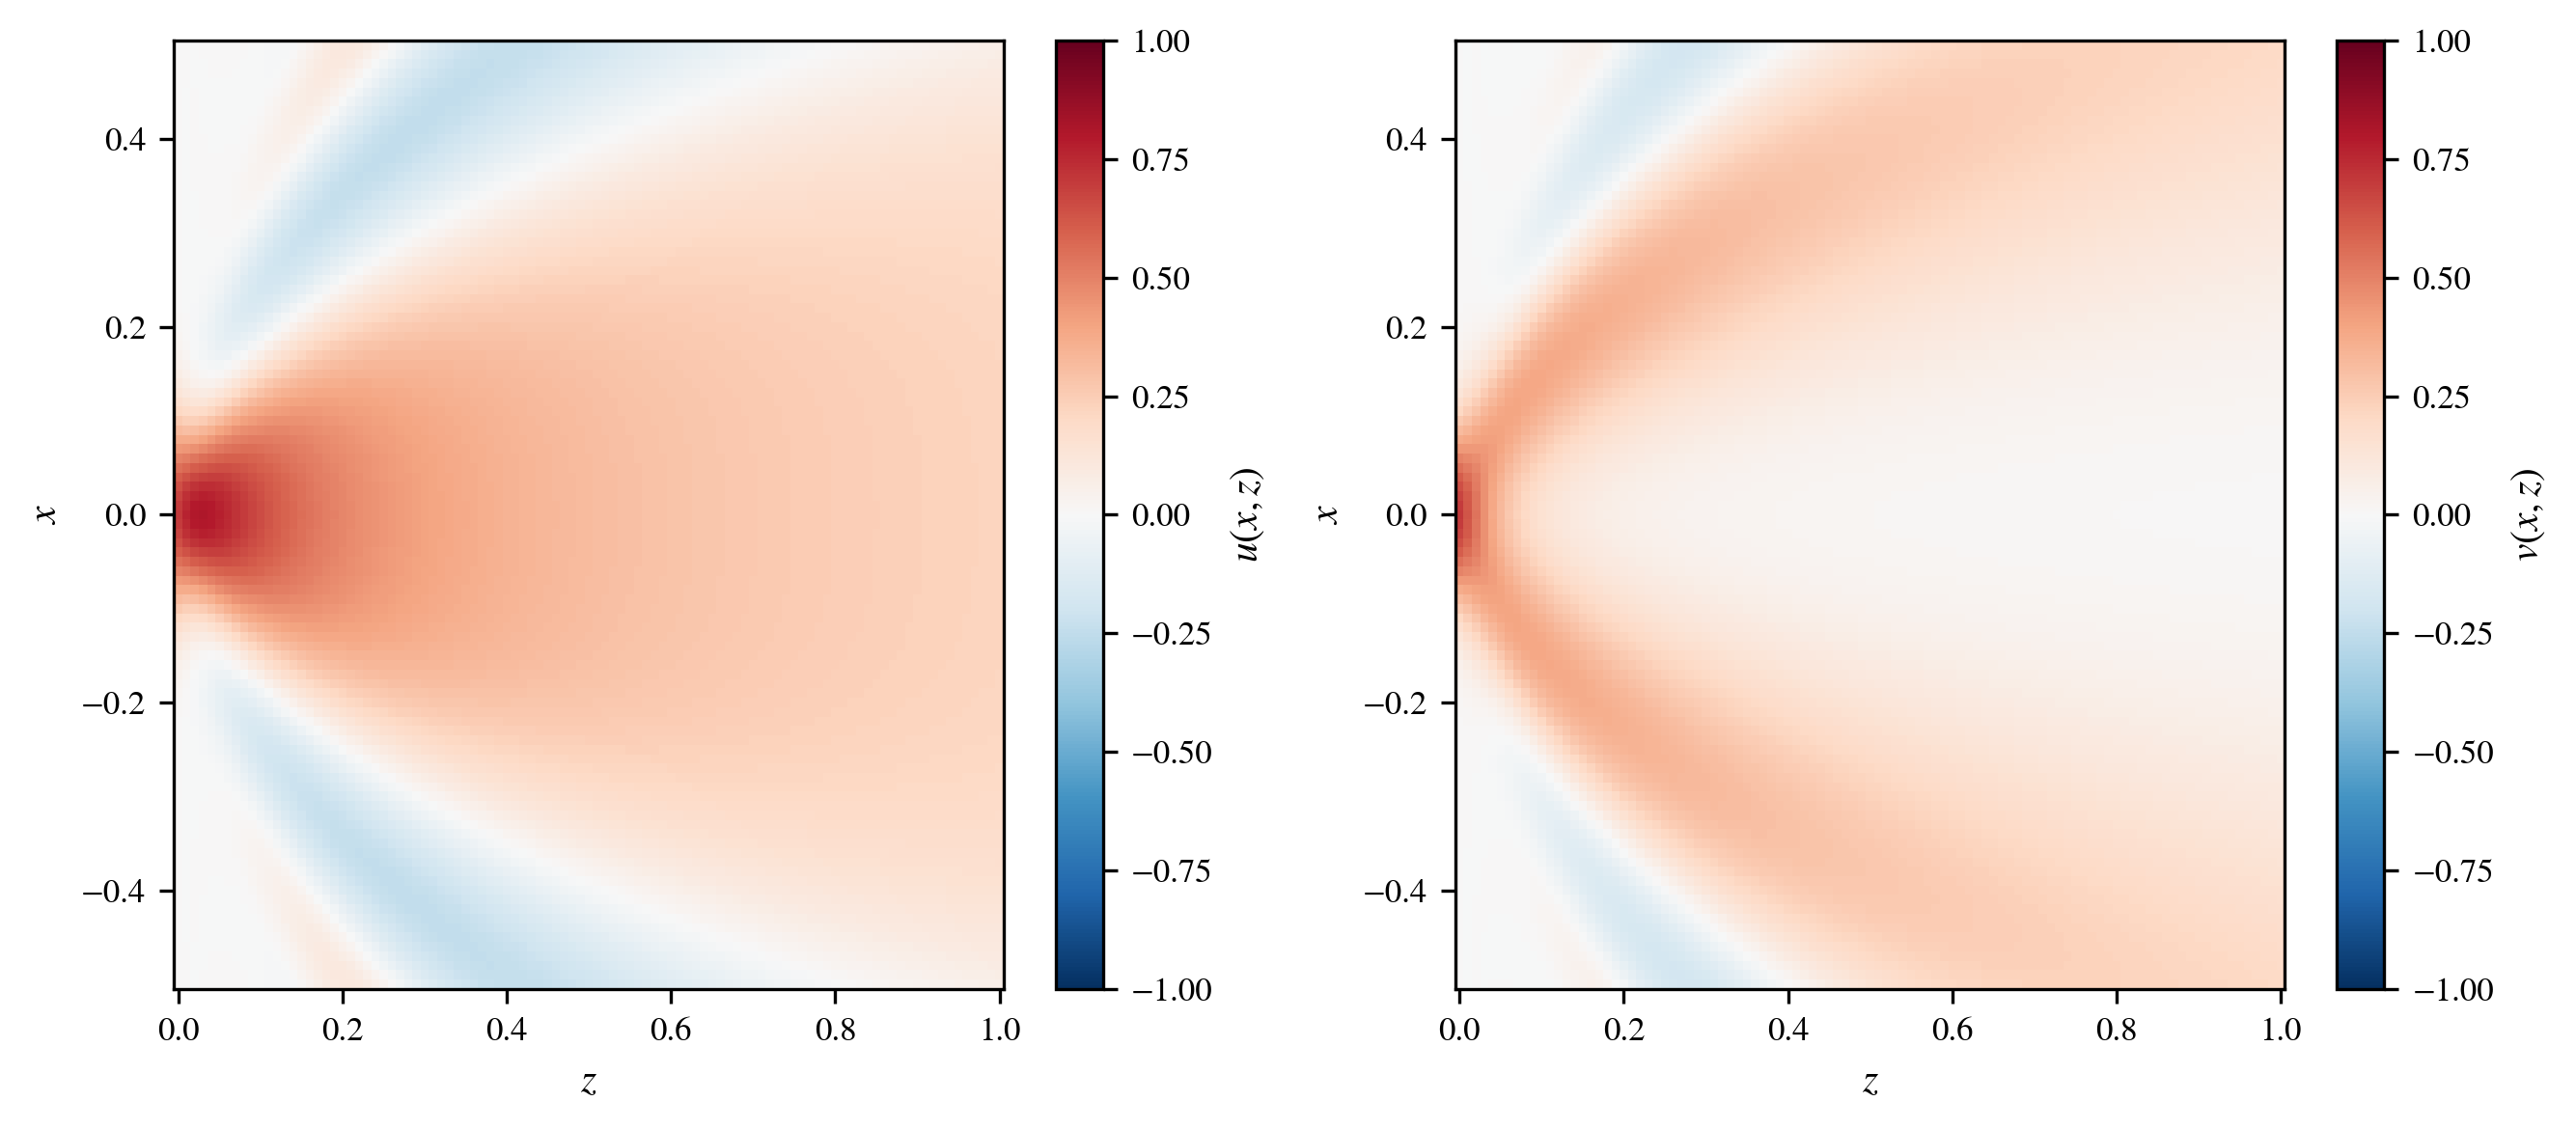

In [16]:
x_np = np.linspace(x_lb, x_ub, num=N_test)
z_np = np.linspace(z_lb, z_ub, num=N_test)

x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=300)

line1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_exact_np(x_npmesh, z_npmesh), vmin=-1, vmax=1, cmap = cm.RdBu_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
#ax1.set_title('exact solution of $u(x,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
cmap1.set_label('$u(x,z)$')

line2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_exact_np(x_npmesh, z_npmesh), vmin=-1, vmax=1, cmap = cm.RdBu_r)
ax2.set_xlabel('$z$')
ax2.set_ylabel('$x$')
#ax2.set_title('exact solution of $v(x,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
cmap2.set_label('$v(x,z)$')

fig.tight_layout()
fig.savefig(f'epochs/reference_calc{number}.png')
    
plt.show()
plt.close()

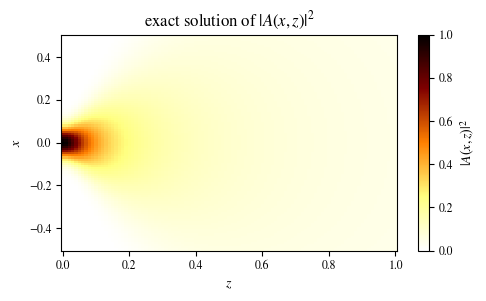

In [17]:
fig, ax1 = plt.subplots(1, dpi=100)
line1 = ax1.pcolormesh(z_npmesh, x_npmesh, np.abs(A_exact_np(x_npmesh, z_npmesh))**2, vmin=0, vmax=1, cmap = cm.afmhot_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('exact solution of $|A(x,z)|^2$')
cmap1 = fig.colorbar(line1, ax=ax1)
cmap1.set_label('$|A(x,z)|^2$')

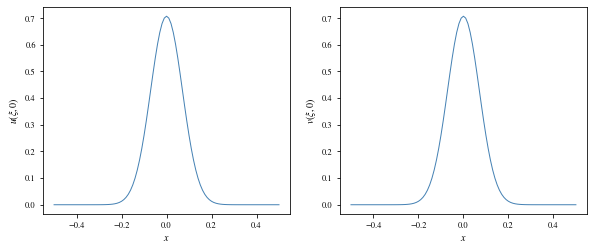

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

ax1.plot(x_np, np.real(A_init(x_np)))
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u(\xi, 0)$')

ax2.plot(x_np, np.imag(A_init(x_np)))
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$v(\xi, 0)$')
plt.show()
plt.close()

### Create all input

In [19]:
# x and z collocation points for PDE residual

x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
XZ = tf.concat([x, z], axis=1)

xtest = np.linspace(x_lb, x_ub, N_test)
ztest = np.linspace(z_lb, z_ub, N_test)
xtestm, ztestm = np.meshgrid(xtest, ztest)
xtestm_resh = xtestm.flatten().reshape(N_test**2, 1)
ztestm_resh = ztestm.flatten().reshape(N_test**2, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for initial condition

z0 = tf.ones((Nbz, 1), dtype=DTYPE) * z_lb
x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
XZ0 = tf.concat([x0, z0], axis=1)

# x and z for boundary conditions

zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
#zb = tf.linspace(z_lb, z_ub, num=Nbx)
#zb = tf.reshape(zb, (Nbx, 1))
xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
XZlb = tf.concat([xlb, zb], axis=1)
xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
XZub = tf.concat([xub, zb], axis=1)

### Function to initialize model

In [20]:
def init_model(L, N):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(2))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'), # why not ReLu?
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

### Function to return the PDE residuals ("physics")

In [21]:
def physics_periodic():
    with tf.GradientTape(persistent=True) as tape:
        x_phy, z_phy = XZ[:, 0:1], XZ[:, 1:2]
        xlb_phy, zlb_phy = XZlb[:, 0:1], XZlb[:, 1:2]
        xub_phy, zub_phy = XZub[:, 0:1], XZub[:, 1:2]
        
        tape.watch(x_phy)
        tape.watch(z_phy)
        tape.watch(xlb_phy)
        tape.watch(zlb_phy)
        tape.watch(xub_phy)
        tape.watch(zub_phy)
        
        A_phy = model((tf.stack([x_phy[:,0], z_phy[:,0]], axis=1)))
        Alb_phy = model((tf.stack([xlb_phy[:,0], zlb_phy[:,0]], axis=1)))
        Aub_phy = model((tf.stack([xub_phy[:,0], zub_phy[:,0]], axis=1)))
        
        u_phy = A_phy[:, 0:1]
        v_phy = A_phy[:, 1:2]
        ulb_phy = Alb_phy[:, 0:1]
        vlb_phy = Alb_phy[:, 1:2]
        uub_phy = Aub_phy[:, 0:1]
        vub_phy = Aub_phy[:, 1:2]      
        
        u_dx = tape.gradient(u_phy, x_phy)
        v_dx = tape.gradient(v_phy, x_phy)
        ulb_dx = tape.gradient(ulb_phy, xlb_phy)
        vlb_dx = tape.gradient(vlb_phy, xlb_phy)
        uub_dx = tape.gradient(uub_phy, xub_phy)
        vub_dx = tape.gradient(vub_phy, xub_phy)
        
    u_dz = tape.gradient(u_phy, z_phy)
    u_dx2 = tape.gradient(u_dx, x_phy)
    v_dz = tape.gradient(v_phy, z_phy)
    v_dx2 = tape.gradient(v_dx, x_phy)
    
    del tape
      
    real_resid = u_dx2 / 5 - 4 * v_dz
    imag_resid = v_dx2 / 5 + 4 * u_dz

    return real_resid, imag_resid, ulb_dx, vlb_dx, uub_dx, vub_dx

In [22]:
def physics_dirichlet():
    with tf.GradientTape(persistent=True) as tape:
        x_phy, z_phy = XZ[:, 0:1], XZ[:, 1:2]
        
        tape.watch(x_phy)
        tape.watch(z_phy)
        
        A_phy = model((tf.stack([x_phy[:,0], z_phy[:,0]], axis=1)))
        
        u_phy = A_phy[:, 0:1]
        v_phy = A_phy[:, 1:2]
        
        u_dx = tape.gradient(u_phy, x_phy)
        v_dx = tape.gradient(v_phy, x_phy)
        
    u_dz = tape.gradient(u_phy, z_phy)
    u_dx2 = tape.gradient(u_dx, x_phy)
    v_dz = tape.gradient(v_phy, z_phy)
    v_dx2 = tape.gradient(v_dx, x_phy)
    
    del tape
      
    real_resid = u_dx2 / 5 - 4 * v_dz
    imag_resid = v_dx2 / 5 + 4 * u_dz

    return real_resid, imag_resid

In [23]:
def physics_periodic2():
    with tf.GradientTape(persistent=True) as tape:
        x_phy, z_phy = XZ[:, 0:1], XZ[:, 1:2]
        
        tape.watch(x_phy)
        tape.watch(z_phy)
        
        A_phy = model((tf.stack([x_phy[:,0], z_phy[:,0]], axis=1)))
        
        u_phy = A_phy[:, 0:1]
        v_phy = A_phy[:, 1:2]
        
        u_dx = tape.gradient(u_phy, x_phy)
        v_dx = tape.gradient(v_phy, x_phy)
        
    u_dz = tape.gradient(u_phy, z_phy)
    u_dx2 = tape.gradient(u_dx, x_phy)
    v_dz = tape.gradient(v_phy, z_phy)
    v_dx2 = tape.gradient(v_dx, x_phy)
    
    del tape
      
    real_resid = u_dx2 / 5 - 4 * v_dz
    imag_resid = v_dx2 / 5 + 4 * u_dz

    return real_resid, imag_resid

### Function to compute loss

In [24]:
u0_exact = u_init(XZ0[:,0:1]) 
v0_exact = v_init(XZ0[:,0:1]) 

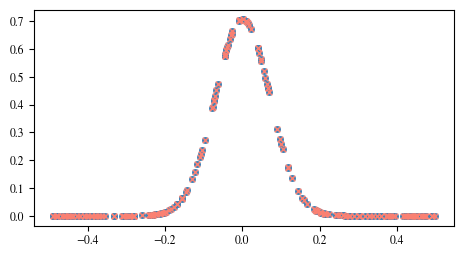

In [25]:
fig, ax = plt.subplots(1, dpi=100)
ax.scatter(XZ0[:,0:1], u0_exact, marker='o', color='steelblue')
ax.scatter(XZ0[:,0:1], v0_exact, marker='x', color='salmon')
plt.show()
plt.close()

In [26]:
def compute_loss_dirichlet_adam():
    real_resid, imag_resid = physics_dirichlet()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi_lb = tf.reduce_mean(tf.square(u_lb_pred)) * phylr[1]
    u_phi_ub = tf.reduce_mean(tf.square(u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_lb = tf.reduce_mean(tf.square(v_lb_pred)) * phylr[1]
    v_phi_ub = tf.reduce_mean(tf.square(v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi_lb + u_phi_ub
    v_phi_bound = v_phi_lb + v_phi_ub
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [27]:
def compute_loss_dirichlet_lbfgs():
    real_resid, imag_resid = physics_dirichlet()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi_lb = tf.reduce_mean(tf.square(u_lb_pred)) * phylr[1]
    u_phi_ub = tf.reduce_mean(tf.square(u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_lb = tf.reduce_mean(tf.square(v_lb_pred)) * phylr[1]
    v_phi_ub = tf.reduce_mean(tf.square(v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi_lb + u_phi_ub
    v_phi_bound = v_phi_lb + v_phi_ub
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss

In [28]:
def compute_loss_periodic_adam():
    real_resid, imag_resid, ulb_dx, vlb_dx, uub_dx, vub_dx = physics_periodic()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) * phylr[1]
    u_phi_dx = tf.reduce_mean(tf.square(ulb_dx - uub_dx)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi = tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) * phylr[1]
    v_phi_dx = tf.reduce_mean(tf.square(vlb_dx - vub_dx)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi + u_phi_dx
    v_phi_bound = v_phi + v_phi_dx
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [29]:
def compute_loss_periodic_lbfgs():
    real_resid, imag_resid, ulb_dx, vlb_dx, uub_dx, vub_dx = physics_periodic()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) * phylr[1]
    u_phi_dx = tf.reduce_mean(tf.square(ulb_dx - uub_dx)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi = tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) * phylr[1]
    v_phi_dx = tf.reduce_mean(tf.square(vlb_dx - vub_dx)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi + u_phi_dx
    v_phi_bound = v_phi + v_phi_dx
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss

In [30]:
def compute_loss_periodic3_adam():
    real_resid, imag_resid, ulb_dx, vlb_dx, uub_dx, vub_dx = physics_periodic()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) * phylr[1]
    u_phi_dx = (tf.reduce_mean(tf.square(ulb_dx)) + tf.reduce_mean(tf.square(uub_dx))) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi = tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) * phylr[1]
    v_phi_dx = (tf.reduce_mean(tf.square(vlb_dx)) + tf.reduce_mean(tf.square(vub_dx))) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi + u_phi_dx
    v_phi_bound = v_phi + v_phi_dx
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [31]:
def compute_loss_periodic3_lbfgs():
    real_resid, imag_resid, ulb_dx, vlb_dx, uub_dx, vub_dx = physics_periodic()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) * phylr[1]
    u_phi_dx = (tf.reduce_mean(tf.square(ulb_dx)) + tf.reduce_mean(tf.square(uub_dx))) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi = tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) * phylr[1]
    v_phi_dx = (tf.reduce_mean(tf.square(vlb_dx)) + tf.reduce_mean(tf.square(vub_dx))) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi + u_phi_dx
    v_phi_bound = v_phi + v_phi_dx
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss

In [32]:
def compute_loss_periodic2_adam():
    real_resid, imag_resid = physics_periodic2()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi = tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi
    v_phi_bound = v_phi
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [33]:
def compute_loss_periodic2_lbfgs():
    real_resid, imag_resid = physics_periodic2()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi = tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi
    v_phi_bound = v_phi
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss

### Function to get gradients

In [34]:
def get_grad_dirichlet():
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_dirichlet_adam()
        
    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

In [35]:
def get_grad_periodic():
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_periodic_adam()
        
    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

In [36]:
def get_grad_periodic2():
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_periodic2_adam()
        
    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

In [37]:
def get_grad_periodic3():
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_periodic3_adam()
        
    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

### Function to execute one full training step

In [38]:
@tf.function
def trainstep_periodic_adam():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad_periodic()
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [39]:
@tf.function
def trainstep_periodic2_adam():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad_periodic2()
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [40]:
@tf.function
def trainstep_periodic3_adam():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad_periodic3()
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [41]:
@tf.function
def trainstep_dirichlet_adam():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad_dirichlet()
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [42]:
@tf.function
def trainstep_periodic_lbfgs():
    dde.optimizers.tfp_optimizer.lbfgs_minimize(trainable_variables, compute_loss_periodic_lbfgs)

In [43]:
@tf.function
def trainstep_periodic2_lbfgs():
    dde.optimizers.tfp_optimizer.lbfgs_minimize(trainable_variables, compute_loss_periodic2_lbfgs)

In [44]:
@tf.function
def trainstep_periodic3_lbfgs():
    dde.optimizers.tfp_optimizer.lbfgs_minimize(trainable_variables, compute_loss_periodic3_lbfgs)

In [45]:
@tf.function
def trainstep_dirichlet_lbfgs():
    dde.optimizers.tfp_optimizer.lbfgs_minimize(trainable_variables, compute_loss_dirichlet_lbfgs)

### Function to do plotting

In [46]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model(epoch):
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)
    line1 = ax1.pcolormesh(ztestm, xtestm, u_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,z)$')
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x$')
    ax1.text(z_lb + z_ub / 10, x_lb + x_ub/10, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    line2 = ax2.pcolormesh(ztestm, xtestm, v_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,z)$')
    ax2.set_xlabel(r'$z$')
    ax2.set_ylabel(r'$x$')
    ax2.text(z_lb + z_ub / 10, x_lb + x_ub/10, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    fig.tight_layout()
    fig.savefig(f'epochs/calc{number}/{epoch}.png')
    plt.close()

### Initialize model, create boundaries, choose optimizer

In [47]:
model = init_model(num_layers, num_nodes)
trainable_variables = model.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

### Curriculum learning

In [48]:
if curriculum:
    model.load_weights(f'final/{curriculum_origin}')
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_periodic_adam()
    print('total ', loss)
    print('real ', real_phi_pde)
    print('imag ', imag_phi_pde)
    print('u bound ', u_phi_bound)
    print('u init ', u_phi_i)
    print('v bound ', v_phi_bound)
    print('v init ', v_phi_i)

### Do some setup before the loop

In [49]:
epoch = 0
loss = 1.
t0 = time()

loss_epoch = []
real_physics_loss_epoch = []
u_bound_loss_epoch = []
u_initial_loss_epoch = []
imag_physics_loss_epoch = []
v_bound_loss_epoch = []
v_initial_loss_epoch = []

### WEGEN TOTALAUSFALL

In [50]:
#model.load_weights(f'weights/calc{number}/12800')
#epoch = 12801

### The loop

#### Adam

In [51]:
while epoch <= maxepoch:
    if boundary_condition == 'periodic':
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep_periodic_adam()
    elif boundary_condition == 'periodic2':
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep_periodic2_adam()
    elif boundary_condition == 'periodic3':
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep_periodic3_adam()
    elif boundary_condition == 'dirichlet':
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep_dirichlet_adam()
    
    if epoch % 100 == 0:
        plot_model(epoch)
        model.save_weights(f'weights/calc{number}/{epoch}')
        
        loss_epoch.append(loss)
        real_physics_loss_epoch.append(real_phi_pde)
        u_bound_loss_epoch.append(u_phi_bound)
        u_initial_loss_epoch.append(u_phi_i)
        imag_physics_loss_epoch.append(imag_phi_pde)
        v_bound_loss_epoch.append(v_phi_bound)
        v_initial_loss_epoch.append(v_phi_i)

        all_losses = np.stack((loss_epoch, real_physics_loss_epoch, imag_physics_loss_epoch, u_bound_loss_epoch, v_bound_loss_epoch, u_initial_loss_epoch, v_initial_loss_epoch) , axis=1)
        
        np.savetxt('loss.txt', all_losses)
        print(f'Elapsed time: {time()-t0:.0f} s on iteration {epoch} with loss {loss:.8f}')
        
    epoch += 1

2022-07-04 06:43:32.825660: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2022-07-04 06:43:34.187943: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Elapsed time: 3 s on iteration 0 with loss 0.36178809
Elapsed time: 11 s on iteration 100 with loss 0.12265489
Elapsed time: 20 s on iteration 200 with loss 0.11861876
Elapsed time: 28 s on iteration 300 with loss 0.10465092
Elapsed time: 37 s on iteration 400 with loss 0.02878370
Elapsed time: 46 s on iteration 500 with loss 0.01152902
Elapsed time: 54 s on iteration 600 with loss 0.00841779
Elapsed time: 63 s on iteration 700 with loss 0.00657230
Elapsed time: 72 s on iteration 800 with loss 0.00546540
Elapsed time: 80 s on iteration 900 with loss 0.00476793
Elapsed time: 89 s on iteration 1000 with loss 0.00430268
Elapsed time: 98 s on iteration 1100 with loss 0.00390922
Elapsed time: 106 s on iteration 1200 with loss 0.00390347
Elapsed time: 115 s on iteration 1300 with loss 0.00342757
Elapsed time: 123 s on iteration 1400 with loss 0.00324201
Elapsed time: 132 s on iteration 1500 with loss 0.00316060
Elapsed time: 141 s on iteration 1600 with loss 0.00303891
Elapsed time: 149 s on

#### L-BFGS

In [52]:
epoch -= 1

while epoch < maxepoch + lbfgs_add:
    if boundary_condition == 'periodic':
        trainstep_periodic_lbfgs()
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_periodic_adam()
    elif boundary_condition == 'periodic2':
        trainstep_periodic2_lbfgs()
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_periodic2_adam()
    elif boundary_condition == 'periodic3':
        trainstep_periodic3_lbfgs()
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_periodic3_adam()
    elif boundary_condition == 'dirichlet':
        trainstep_dirichlet_lbfgs()
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_dirichlet_adam()
    
    loss_epoch.append(loss)
    real_physics_loss_epoch.append(real_phi_pde)
    u_bound_loss_epoch.append(u_phi_bound)
    u_initial_loss_epoch.append(u_phi_i)
    imag_physics_loss_epoch.append(imag_phi_pde)
    v_bound_loss_epoch.append(v_phi_bound)
    v_initial_loss_epoch.append(v_phi_i)

    all_losses = np.stack((loss_epoch, real_physics_loss_epoch, imag_physics_loss_epoch, u_bound_loss_epoch, v_bound_loss_epoch, u_initial_loss_epoch, v_initial_loss_epoch) , axis=1)
    np.savetxt('loss.txt', all_losses)

    epoch += 100
    
    plot_model(epoch)
    model.save_weights(f'weights/calc{number}/{epoch}')   
    
    print(f'Elapsed time: {time()-t0:.0f} s on iteration {epoch} with loss {loss:.8f}')

Elapsed time: 1088 s on iteration 12100 with loss 0.00127254
Elapsed time: 1130 s on iteration 12200 with loss 0.00114117
Elapsed time: 1174 s on iteration 12300 with loss 0.00104281
Elapsed time: 1216 s on iteration 12400 with loss 0.00095539
Elapsed time: 1259 s on iteration 12500 with loss 0.00087487
Elapsed time: 1301 s on iteration 12600 with loss 0.00080248
Elapsed time: 1344 s on iteration 12700 with loss 0.00073461
Elapsed time: 1386 s on iteration 12800 with loss 0.00066848
Elapsed time: 1428 s on iteration 12900 with loss 0.00061299
Elapsed time: 1472 s on iteration 13000 with loss 0.00056469
Elapsed time: 1514 s on iteration 13100 with loss 0.00052839
Elapsed time: 1560 s on iteration 13200 with loss 0.00050038
Elapsed time: 1603 s on iteration 13300 with loss 0.00047421
Elapsed time: 1647 s on iteration 13400 with loss 0.00045279
Elapsed time: 1690 s on iteration 13500 with loss 0.00043722
Elapsed time: 1733 s on iteration 13600 with loss 0.00042409
Elapsed time: 1777 s on 

In [53]:
all_losses = np.stack((loss_epoch, real_physics_loss_epoch, imag_physics_loss_epoch, u_bound_loss_epoch, v_bound_loss_epoch, u_initial_loss_epoch, v_initial_loss_epoch) , axis=1)

plot_model(epoch)
model.save_weights(f'final/calc{number}')
np.savetxt(f'losses/loss_calc{number}.txt', all_losses)
print(f'Final time: {time()-t0:.0f} s on final iteration {epoch} with final loss {loss:.8f}')

Final time: 2337 s on final iteration 15000 with final loss 0.00032265


### Testing ground

In [54]:
A_plot = model(XZtest)
u_plot_pre = A_plot[:, 0:1]
v_plot_pre = A_plot[:, 1:2]

u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
v_plot = v_plot_pre.numpy().reshape(N_test, N_test)

u_comp = u_exact_np(x_npmesh, z_npmesh)
v_comp = v_exact_np(x_npmesh, z_npmesh)

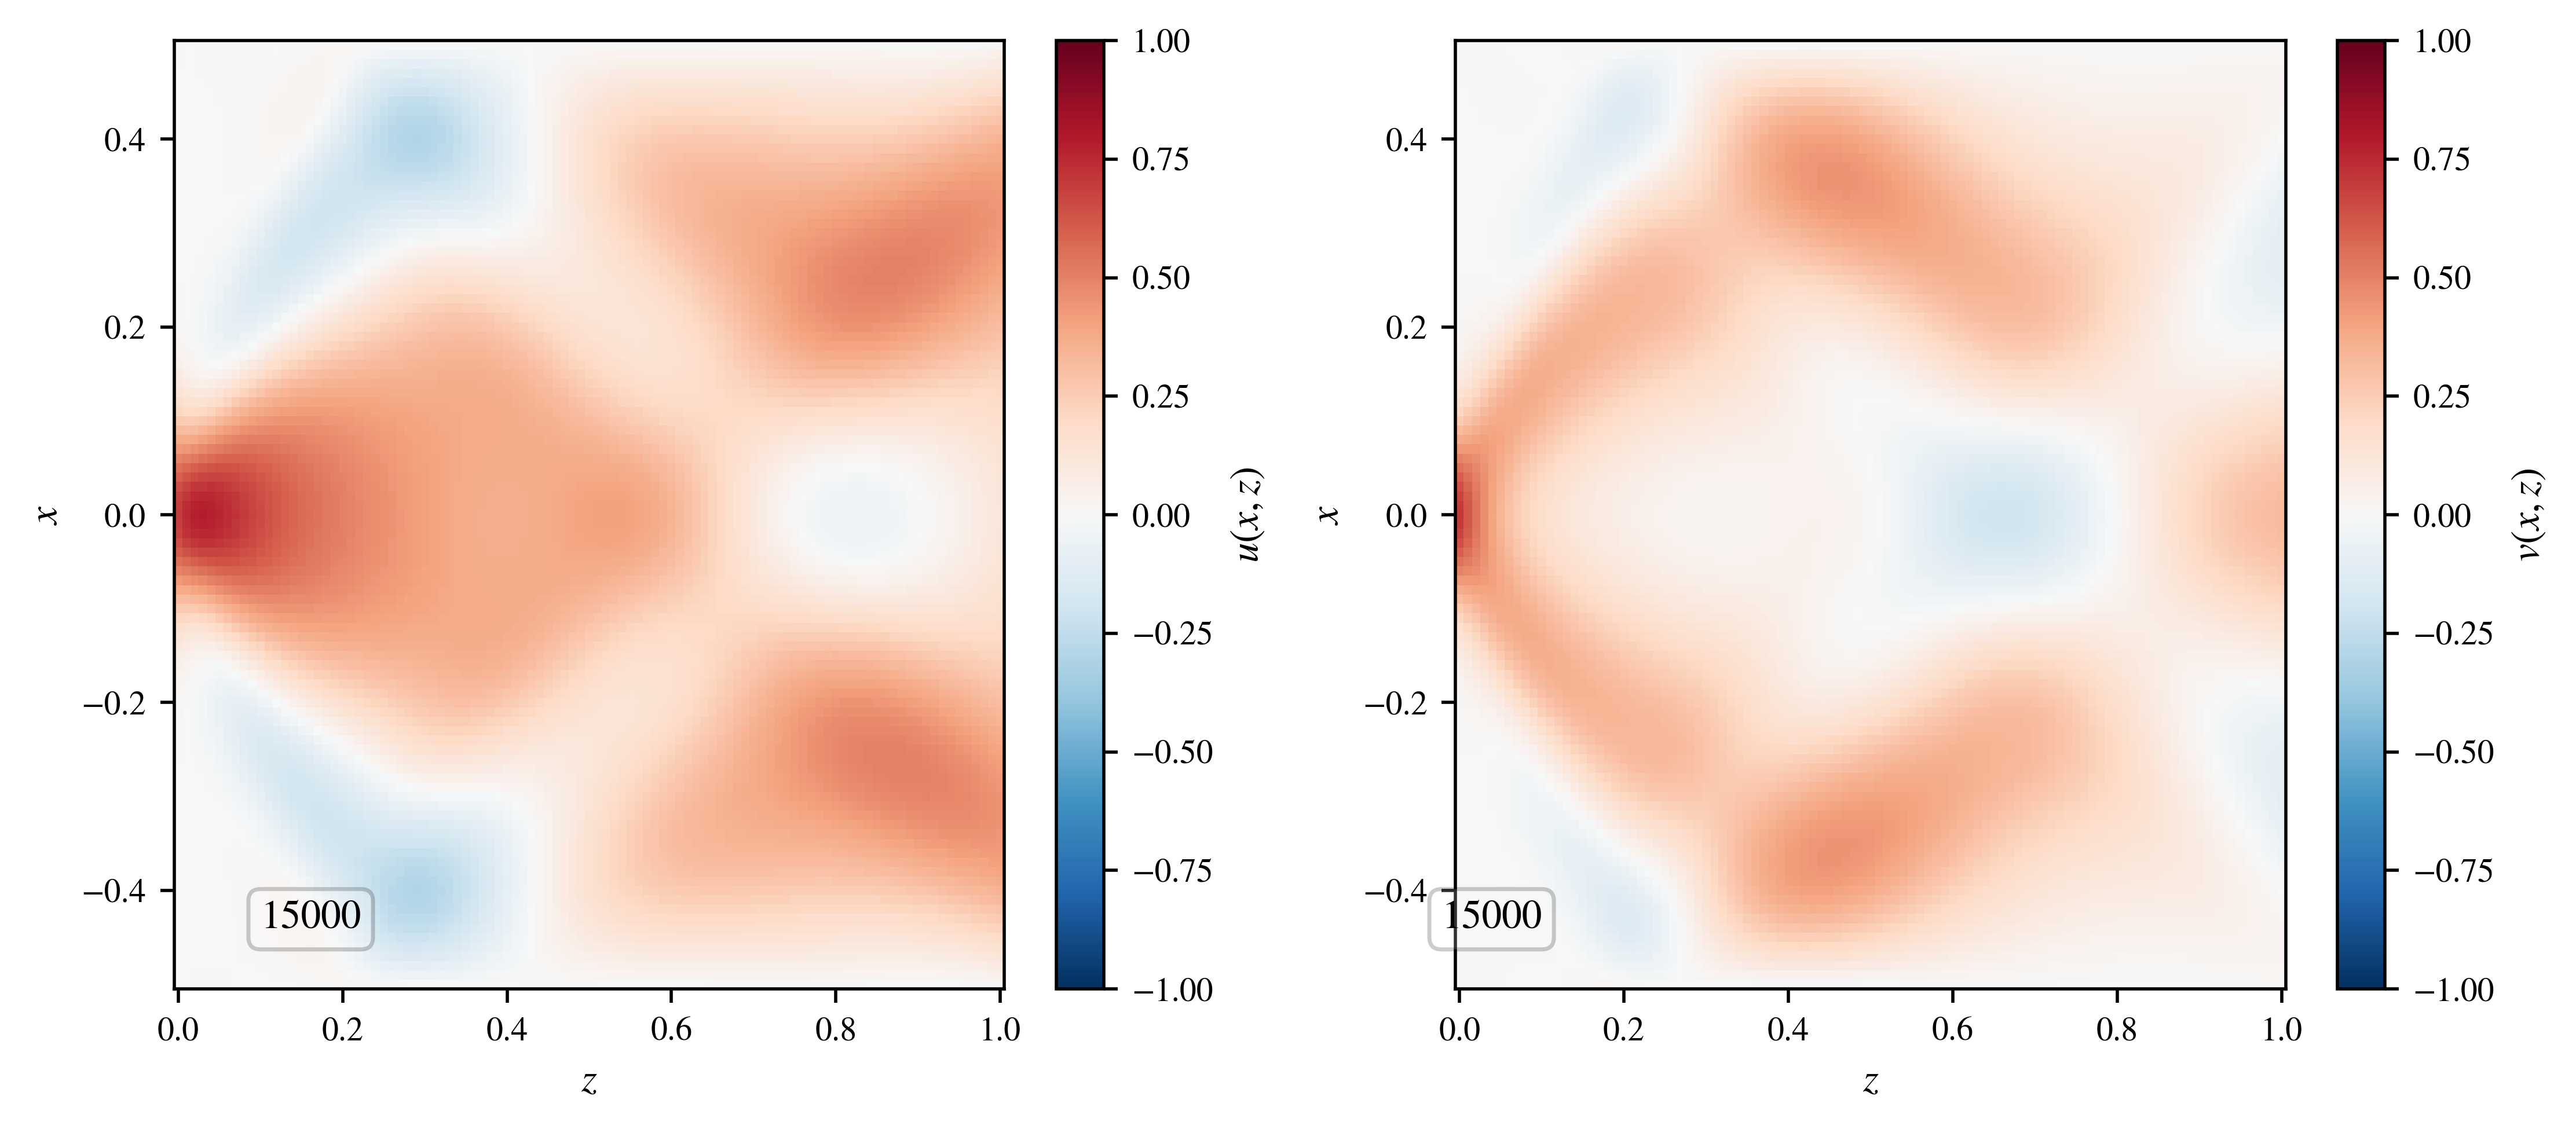

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)
line1 = ax1.pcolormesh(ztestm, xtestm, u_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
cbar1 = fig.colorbar(line1, ax=ax1)
cbar1.set_label(r'$u(x,z)$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$x$')
ax1.text(z_lb + z_ub / 10, x_lb + x_ub/10, str(epoch), fontsize=10,
       verticalalignment='bottom', horizontalalignment='left', bbox=props)

line2 = ax2.pcolormesh(ztestm, xtestm, v_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
cbar2 = fig.colorbar(line2, ax=ax2)
cbar2.set_label(r'$v(x,z)$')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$x$')
ax2.text(z_lb + z_ub / 10, x_lb + x_ub/10, str(epoch), fontsize=10,
       verticalalignment='bottom', horizontalalignment='right', bbox=props)

fig.tight_layout()
plt.show()
plt.close()

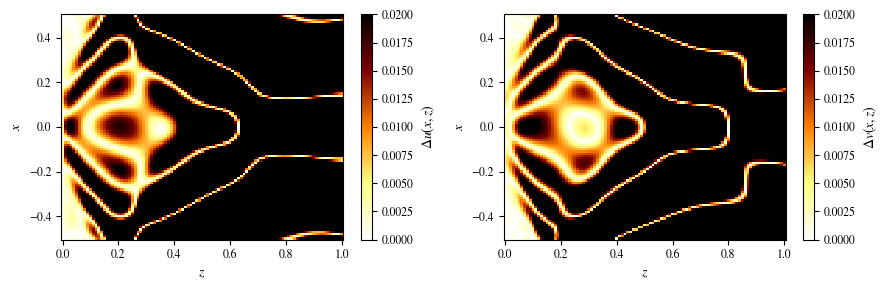

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3), dpi=100)
line1 = ax1.pcolormesh(ztestm, xtestm, np.abs(u_plot - u_comp), cmap = cm.afmhot_r, vmin=0, vmax=0.02)
cbar1 = fig.colorbar(line1, ax=ax1)
cbar1.set_label(r'$\Delta u(x,z)$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$x$')
line2 = ax2.pcolormesh(ztestm, xtestm, np.abs(v_plot - v_comp), cmap = cm.afmhot_r, vmin=0, vmax=0.02)
cbar2 = fig.colorbar(line2, ax=ax2)
cbar2.set_label(r'$\Delta v(x,z)$')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$x$')
fig.tight_layout()
plt.show()
plt.close()

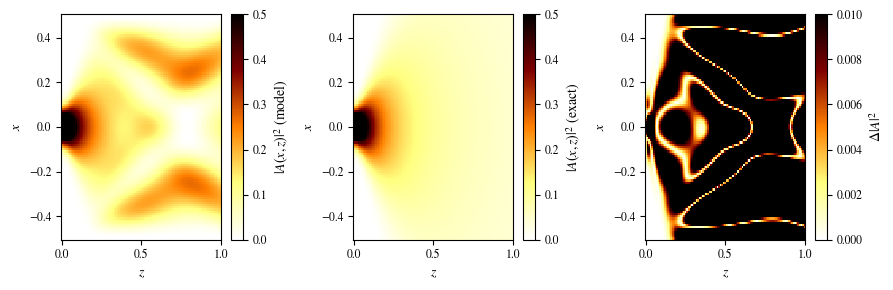

In [57]:
fig, (ax2, ax3, ax1) = plt.subplots(1,3, figsize=(9,3), dpi=100)

dummy = np.abs(u_plot**2 + v_plot**2 - u_comp**2 - v_comp**2)

line1 = ax1.pcolormesh(ztestm, xtestm, dummy, cmap = cm.afmhot_r, vmin=0, vmax=.01)
cbar1 = fig.colorbar(line1, ax=ax1)
cbar1.set_label(r'$\Delta |A|^2$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$x$')

line3 = ax3.pcolormesh(ztestm, xtestm, u_comp**2 + v_comp**2, cmap = cm.afmhot_r, vmin=0, vmax=.5)
cbar3 = fig.colorbar(line3, ax=ax3)
cbar3.set_label(r'$|A(x,z)|^2$ (exact)')
ax3.set_xlabel(r'$z$')
ax3.set_ylabel(r'$x$')

line2 = ax2.pcolormesh(ztestm, xtestm, u_plot**2 + v_plot**2, cmap = cm.afmhot_r, vmin=0, vmax=.5)
cbar2 = fig.colorbar(line2, ax=ax2)
cbar2.set_label(r'$|A(x,z)|^2$ (model)')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$x$')

fig.tight_layout()
plt.show()
plt.close()

In [58]:
u_diff = np.abs(u_plot - u_comp)
v_diff = np.abs(v_plot - v_comp)
int_plot = u_plot**2 + v_plot**2
int_comp = u_comp**2 + v_comp**2
int_diff = np.abs(int_plot - int_comp)

l2u = np.sqrt( np.sum(np.sum( u_diff**2 , axis=1)) /  np.sum(np.sum( u_plot**2 , axis=1))  )
l2v = np.sqrt( np.sum(np.sum( v_diff**2 , axis=1)) /  np.sum(np.sum( v_plot**2 , axis=1))  )
l2i = np.sqrt( np.sum(np.sum( int_diff**2 , axis=1)) /  np.sum(np.sum( int_plot**2 , axis=1))  )

print('L2 of u is ', l2u)
print('L2 of v is ', l2v)
print('L2 of int is ', l2i)

L2 of u is  0.434292126408935
L2 of v is  0.5147242110185761
L2 of int is  0.45128942306046266


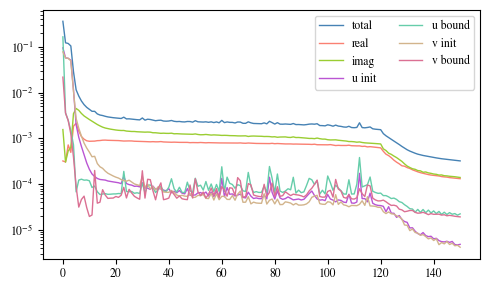

In [59]:
fig, ax = plt.subplots(1, dpi=100)
ax.plot(loss_epoch, label='total')
ax.plot(real_physics_loss_epoch, label='real')
ax.plot(imag_physics_loss_epoch, label='imag')
ax.plot(u_initial_loss_epoch, label='u init')
ax.plot(u_bound_loss_epoch, label='u bound')
ax.plot(v_initial_loss_epoch, label='v init')
ax.plot(v_bound_loss_epoch, label='v bound')
ax.legend(loc='upper right', ncol=2)
ax.set_yscale('log')
fig.tight_layout()
plt.show()
plt.close()

# Checklist of bugfixing

### check physics

- [x] PDEs correct?
- [x] implementation correct?

### check code

- [x] plotting correct?
- [x] check every damn line of code (yay)

### does it work?

- [x] yes